<a href="https://colab.research.google.com/github/camulro/Aprendizaje-II/blob/sesi%C3%B3n4/dcgan_EJERCICIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#CA0032"><h1 align="left">**Redes Generativas Adversariales (GANs)**</h1></font>

<font color="#6E6E6E"><h1 align="left">**Creación de imágenes nuevas:**</h1></font>

<font color="#6E6E6E"><h1 align="left">**Modelos Deep Learning**</h1></font>

<h2 align="left">Manuel Sánchez-Montañés</h2>

<font color="#6E6E6E"><h2 align="left">manuel.smontanes@gmail.com</h2></font>

In [ ]:
COLAB                  = True
SAVE_INTERMEDIATE_DATA = False

In [ ]:
if COLAB:
    %tensorflow_version 1.x
    !pip install h5py==2.10.0

import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import fashion_mnist as fashion
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

%matplotlib inline

TensorFlow 1.x selected.
     |████████████████████████████████| 2.9 MB 5.5 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


Using TensorFlow backend.


In [ ]:
# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

In [ ]:
# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100//5 # sin //5 ok

# Load data
(X_train, y_train), (X_test, y_test) = fashion.load_data()
X_train = X_train.astype(np.float32) / 255 # para que esté entre 0 y 1
X_train = 2*X_train - 1 # para que esté entre -1 y 1
print(X_train.shape)

X_train = X_train.reshape(X_train.shape + (1,))
print(X_train.shape)

X_train = X_train[y_train>=5] # para simplificar se entrena sólo con las clases 0,1,2,3,4
y_train = y_train[y_train>=5] # ídem

4423680/4422102 [==============================] - 1s 0us/step
(60000, 28, 28)
(60000, 28, 28, 1)


In [ ]:
#from sklearn.model_selection import train_test_split
#X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=0.33, random_state=0)

In [ ]:
X_train.shape

(30000, 28, 28, 1)

**Optimizador**

In [ ]:
#adam = Adam(lr=0.0002, beta_1=0.5)
adam_gen  = Adam(lr=0.0002, beta_1=0.5)
adam_disc = Adam(lr=0.0002/2, beta_1=0.5)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


**Generador**

In [ ]:
randomDim

20

In [ ]:
7*7*32

1568

In [ ]:
?UpSampling2D #te añade píxeles

In [ ]:
1 5 3
8 9 2
0 1 0

1 1 5 5 3 3
1 1 5 5 3 3
8 8 9 9 2 2
8 8 9 9 2 2
0 0 1 1 0 0
0 0 1 1 0 0

In [ ]:
generator = Sequential()
generator.add(Dense(32*7*7, input_shape=(randomDim,),
                    kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7,7,32)))

generator.add(UpSampling2D(size=(2,2))) 
generator.add(Conv2D(8, kernel_size=(3,3), padding="same"))
generator.add(LeakyReLU(0.2))

generator.add(UpSampling2D(size=(2,2)))
generator.add(Conv2D(1, kernel_size=(5,5), padding="same", activation="tanh")) # imágenes de 28x28x1

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1568)              32928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1568)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 8)         2312      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 8)         0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 28, 28, 8)        

**Discriminador**

In [ ]:
from keras.layers import MaxPool2D

In [ ]:
X_train.shape

(30000, 28, 28, 1)

In [ ]:
discriminator = Sequential()
discriminator.add(Conv2D(16, kernel_size=(5,5), input_shape=(28,28,1),
                         kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(MaxPool2D(2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(32, kernel_size=(3,3)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(MaxPool2D(2))
discriminator.add(Flatten())
discriminator.add(Dropout(0.3))
discriminator.add(Dense(100))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(1, activation="sigmoid"))
discriminator.compile(loss="binary_crossentropy", optimizer=adam_disc)
discriminator.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 24, 16)        416       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 24, 24, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 32)        4640      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 10, 10, 32)        0         
_________________________

**Red combinada (sistema GAN)**

In [ ]:
# rellenar

discriminator.trainable = False
ganInput  = Input(shape=(randomDim,))
ganOutput = discriminator(generator(ganInput))
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss="binary_crossentropy", optimizer=adam_gen)

gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20)                0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         35441     
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 85257     
Total params: 120,698
Trainable params: 35,441
Non-trainable params: 85,257
_________________________________________________________________


In [ ]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 3))
    plt.plot(range(1,len(dLosses)+1), dLosses,
             label='Discriminitive loss', linewidth=3)
    plt.plot(range(1,len(gLosses)+1), gLosses,
             label='Generative loss', linewidth=3)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(fontsize=14)
    if not COLAB:
        plt.savefig('./images/dcgan_loss_epoch_{}.png'.format(epoch))
    plt.show()

# Create a wall of generated images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
#        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.imshow(generatedImages[i,:,:,0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    if SAVE_INTERMEDIATE_DATA:
        plt.savefig('./images/dcgan_generated_image_epoch_{}.png'.format(epoch))
    plt.show()

    
def plotImages(images, nrows, ncols, figsize):
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(images[i,:,:,0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    

# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('models/dcgan_generator_epoch_{}.h5'.format(epoch))
    discriminator.save('models/dcgan_discriminator_epoch_{}.h5'.format(epoch))

In [ ]:
if SAVE_INTERMEDIATE_DATA:
    os.makedirs("./images", exist_ok=True)
    os.makedirs("./models", exist_ok=True)

In [ ]:
dLosses = [] # histórico de los valores de la función de coste del discriminador
gLosses = [] # histórico de los valores de la función de coste del generador

In [ ]:
epochs=50
batchSize=128
epocas_refrescar_grafica=1

batchCount = len(X_train) // batchSize
print('Epochs:', epochs)
print('Batch size:', batchSize)
print('Batches per epoch:', batchCount)

for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for _ in tqdm(range(batchCount)):
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batchSize, randomDim])
        imageBatch = X_train[np.random.randint(0, len(X_train), size=batchSize)]
        
        # Generate fake images
        generatedImages = generator.predict(noise)
        X = np.concatenate([imageBatch, generatedImages])
        
        # Labels for generated and real data
        # los primeros batchSize ejemplos tienen etiqueta 0.9
        # (imagen real)
        # Los últimos batchSize ejemplos tienen etiqueta 0 (fake)
        yDis = np.zeros(2*batchSize)
        # One-sided label smoothing
        yDis[:batchSize] = 0.9
        
        # Train discriminator
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, yDis)
        
        # Train generator
        noise = np.random.normal(0, 1, size=[batchSize, randomDim])
        yGen = np.ones(batchSize)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise, yGen)
        
    # Store loss of most recent batch from this epoch
    dLosses.append(dloss)
    gLosses.append(gloss)
    
    if (e==1) or ((e%epocas_refrescar_grafica)==0):
        plotGeneratedImages(e)
        if SAVE_INTERMEDIATE_DATA:
            saveModels(e)
    if (e%epocas_refrescar_grafica)==0:
        plotLoss(e)

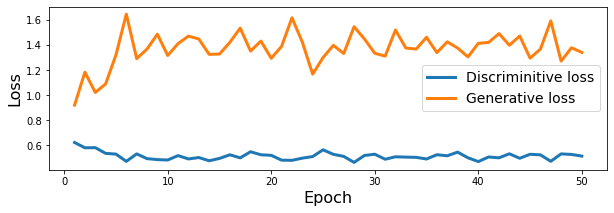

In [ ]:
# Plot losses from every epoch
plotLoss(e)

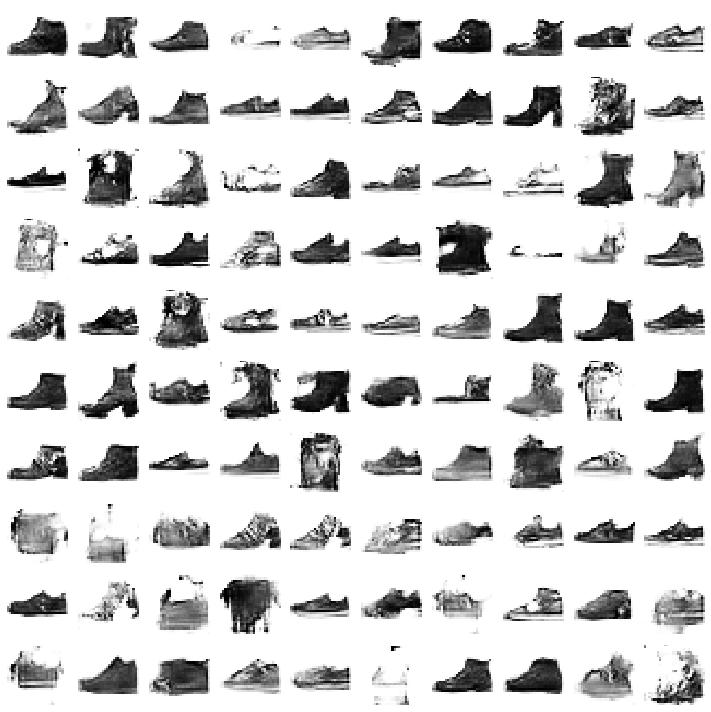

In [ ]:
# Generación de 100 imágenes nuevas:

n_imagenes = 100

noise = np.random.normal(0, 1, size=[n_imagenes, randomDim])
generatedImages = generator.predict(noise)
plotGeneratedImages(e+1)

Ahora generamos un conjunto de vectores de entrada a la GAN. Cada vector de entrada tiene **randomDim** componentes: (queremos movernos ahora poco a poco)

In [ ]:
nrows = 5
ncols = 10
input0 = np.zeros((nrows*ncols, randomDim))
caso = 0
for i in range(nrows):
    for j in range(ncols):
        input_id = i+10
        input0[caso,input_id] = -2+4*j/(ncols-1)
        caso = caso + 1
        


In [ ]:
# Vamos a mostrar los resultados obtenidos para el conjunto de vectores
# de entrada en una matriz de nfilas * ncols:
nfilas = 5
ncols  = 10

# Inicializo a 0 el conjunto de vectores de entrada a la GAN:
input0 = np.zeros((nfilas*ncols, randomDim))

# Termino de calcular el conjunto de vectores de entrada.
# La idea es que en cada fila las componentes diferentes de cero
# son las mismas, y sus valores cambian de columna a columna:

nvector = 0
for i in range(nfilas):
    # Qué componentes de las randomDim se van a perturbar:
    componentes_pert = range(15+i,15+i+1)
    for j,x in enumerate(np.linspace(-2, 2, ncols)):
        input_id = i+0
        input0[nvector][componentes_pert] = x
        nvector = nvector + 1

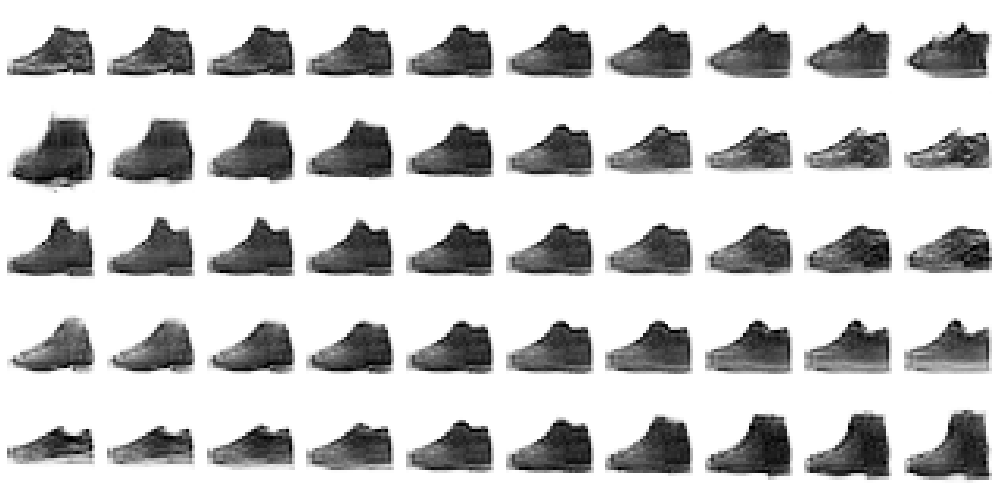

In [ ]:
generatedImages = generator.predict(input0)
plotImages(generatedImages, nfilas, ncols, figsize=(14,7))

In [ ]:
generatedImages.shape

In [ ]:
# Para grabar las redes a fichero:

generator.save("./dcgan_generator.h5")
generator.save_weights("./dcgan_generator_weights.h5")
discriminator.save("./dcgan_discriminator.h5")
discriminator.save_weights("./dcgan_discriminator_weights.h5")
gan.save("./dcgan_gan.h5")
gan.save_weights("./dcgan_gan_weights.h5")

Para descargar el modelo a local si estamos en Colab:

In [ ]:
if COLAB:
    from google.colab import files
    files.download('./dcgan_generator.h5')
    files.download('./dcgan_generator_weights.h5')
    files.download('./dcgan_discriminator.h5')
    files.download('./dcgan_discriminator_weights.h5')
    files.download('./dcgan_gan.h5')
    files.download('./dcgan_gan_weights.h5')

Si quisiésemos realizar **data augmentation** desde otro script, haríamos lo siguiente:

In [ ]:
from keras.models import load_model

model_data_augmentation = load_model("./dcgan_generator.h5")

In [ ]:
model_data_augmentation.summary()

In [ ]:
model_data_augmentation.input_shape

In [ ]:
numero_patrones_sinteticos = 1000
tam_entrada_generador = model_data_augmentation.input_shape[-1]
input_gen = np.random.randn(numero_patrones_sinteticos, tam_entrada_generador)

patrones_nuevos = model_data_augmentation.predict(input_gen)

In [ ]:
patrones_nuevos.shape

In [ ]:
plotImages(patrones_nuevos[:20], nfilas, ncols, figsize=(14,7))

Ejercicio:

- Adaptar el ejercicio a la base de datos CIFAR-10

In [ ]:
from tensorflow.keras.datasets.cifar10 import load_data as load_data_cifar10

In [ ]:
?load_data_cifar10